In [186]:
# We will use the following libraries in this script
library(bnlearn)
library(Rgraphviz)
library(gRain)
library(dplyr) # to use %>%

In [188]:
# Function to select predictors from a CSV file (DATA.csv)
select_predictors <- function(csv_file, predictor_prefixes, target){
  data <- read.csv(csv_file, colClasses = "character") %>%
    select(-ID) %>%
    mutate(across(everything(), as.factor))
  variables <- names(data)[grepl(paste(predictor_prefixes, collapse = "|"), names(data))]
  variables <- c(variables, target)
  return(data[, variables, drop = FALSE])
}

# Function to create the structure of the Bayesian Network using hc
create_structure <- function(data){
  model <- hc(data)
  return(model)
}

# We avoid cycles in the final network
remove_cycles <- function(arcs){
  return(unique(arcs))
}

# Function to draw the final DAG and show the strength of the arcs
draw_final_dag <- function(arcs, nodes, mmarkov, target, data, size){
  arcs <- remove_cycles(arcs)
  dag <- empty.graph(nodes)
  arcs(dag) <- arcs
  print(modelstring(dag))
  g <- graphviz.plot(dag, render = FALSE)
  attrs <- list(node = list(shape = "ellipse", fontsize = 30, fillcolor = "lightgrey", style = "filled"),
                edge = list(arrowsize = 1))
  graph::graphRenderInfo(g) <- attrs
  colors <- color_nodes(nodes, mmarkov, target)
  graph::nodeRenderInfo(g)$fill <- colors
  graph::nodeRenderInfo(g)$col <- "black"
  graph::nodeRenderInfo(g)$textCol <- "black"
  graph::nodeRenderInfo(g)$fontsize <- 30
  variables <- intersect(names(data), nodes)
  data <- data[, variables, drop = FALSE]
  arc_strengths <- suppressWarnings(arc.strength(dag, data = data, criterion = "bic"))
  arc_strengths <- arc_strengths[order(-arc_strengths$strength), ]
  arc_strengths$abs_strength <- abs(as.numeric(sub(".*?(-?\\d+).*", "\\1", as.character(arc_strengths$strength))))
  arc_strengths$width <- cut(arc_strengths$abs_strength, breaks = c(-Inf, 10, 20, 50, 100, 200, Inf), labels = c(1, 2, 3, 4, 5, 6))
  edge_weights <- setNames(as.numeric(arc_strengths$width), paste(arc_strengths$from, arc_strengths$to, sep = "~"))
  edgeRenderInfo(g)$lwd <- edge_weights
  edgeRenderInfo(g)$col <- "black"
  print("Ordered by strength:")
  print(arc_strengths[, c("from", "to", "strength", "abs_strength", "width")])
  Rgraphviz::renderGraph(g)
}

# Function to color the nodes
color_nodes <- function(nodes, mmarkov, target) {
  sapply(nodes, function(node) {
    if (node %in% mmarkov) {
      "yellow1"
    } else if (node == target) {
      "yellow2"
    } else if (startsWith(node, "MH")) {
      "lightblue1"
    } else if (startsWith(node, "TRT")) {
      "lightsalmon1"
    } else if (startsWith(node, "SOC")) {
      "olivedrab1"
    } else {
      "white"
    }
  })
}

# Function to bootstrap the DAG using 100 iterations (100 by default)
create_dag_bootstrap <- function(file, target, predictor_prefixes, n_iter = 100, seed = 1){
  set.seed(seed)
  data <- select_predictors(file, predictor_prefixes, target)
  results <- list()
  for (i in 1:n_iter) {
    sample <- data[sample(nrow(data), replace = TRUE), ]
    structure <- create_structure(sample)
    arcs <- arcs(structure)
    nodes <- nodes(structure)
    mmarkov <- mb(structure, node = target)
    results[[i]] <- list(structure = structure, arcs = arcs, nodes = nodes, mmarkov = mmarkov)
  }
  return(results)
}

# Function to calculate the frequency of the arcs
calculate_arc_frequency <- function(results){
  arcs_list <- lapply(results, function(res) {
    arcs <- res$arcs
    data.frame(from = arcs[, 1], to = arcs[, 2])
  })
  combined_arcs <- do.call(rbind, arcs_list)
  arcs_table <- as.data.frame(table(paste(combined_arcs$from, combined_arcs$to, sep = "~")))
  arcs_table <- arcs_table[order(-arcs_table$Freq), ]
  separated_arcs <- as.data.frame(do.call(rbind, strsplit(as.character(arcs_table$Var1), "~")))
  colnames(separated_arcs) <- c("from", "to")
  arcs_table <- cbind(separated_arcs, arcs_table$Freq)
  colnames(arcs_table) <- c("from", "to", "Freq")
  return(arcs_table)
}

# Function to check if an arc exists in the graph, we will use it to avoid some arcs (MH_AGE -> XX_XXXX ; MH_SEX -> XX_XXXX)
arc_exists <- function(graph, from, to) {
  present_arc <- arcs(graph)
  return(any(present_arc[, 1] == from & present_arc[, 2] == to) ||
         any(present_arc[, 1] == to & present_arc[, 2] == from))
}

# Function to create the final network
create_final_network <- function(arc_frequency, threshold = 50) {
  filtered_arcs <- arc_frequency %>% filter(Freq >= threshold)
  nodes <- unique(c(filtered_arcs$from, filtered_arcs$to))
  final_network <- empty.graph(nodes)
  for (i in 1:nrow(filtered_arcs)) {
    from <- as.character(filtered_arcs$from[i])
    to <- as.character(filtered_arcs$to[i])
    if (!is.null(from) && !is.null(to) && !arc_exists(final_network, from, to)) {
      if (to != "MH_AGE" && to != "MH_SEX") {
        try(final_network <- set.arc(final_network, from, to), silent = TRUE)
      }
    }
  }
  return(final_network)
}

# Function to calculate the number of parameters in the network
calculate_number_of_parameters <- function(bn_object) {
  params <- nparams(bn_object)
  return(params)
}

# Function to calculate the probabilities
calculate_probabilities <- function(bn_fitted, variable) {
  cpt <- bn_fitted[[variable]]
  return(cpt)
}

# Function to compare two variables with a barplot and a chi-square test
compare_variables <- function(file, variable1, variable2){
  data <- read.csv(file, colClasses = "character") %>%
           select(-ID) %>%
           mutate(across(everything(), as.factor)) %>%
           na.omit()
  test_result <- ci.test(variable1, variable2, data = data)
  print(test_result)
  table <- table(data[, variable1], data[, variable2])
  barplot(table, beside = TRUE, legend = TRUE, col = rainbow(nrow(table)), 
          xlab = variable2, ylab = "Frequency", main = paste("Distribution of", variable1, "over", variable2))
}

# Function to create a bar chart for a specific variable using bn.fit.barchart
create_barchart <- function(bn_fitted, variable) {
  bn.fit.barchart(bn_fitted[[variable]])
}

# MAIN FUNCTION
perform_analysis <- function(file, target, predictor_prefixes, n_iter = 100, threshold = 40, seed = 1){
  bootstrap_results <- create_dag_bootstrap(file, target, predictor_prefixes, n_iter, seed)
  arc_frequency <- calculate_arc_frequency(bootstrap_results)
  print(arc_frequency)
  BNet <- create_final_network(arc_frequency, threshold)
  print(arcs(BNet))
  network_variables <- nodes(BNet)
  final_data <- select_predictors(file, predictor_prefixes, target)[, network_variables, drop = FALSE]
  bn_fitted <- bn.fit(BNet, data = final_data, method = "bayes")
  number_of_parameters <- calculate_number_of_parameters(bn_fitted)
  print(number_of_parameters)
  draw_final_dag(arcs(BNet), nodes(BNet), mb(BNet, target), target, final_data, size = 15)
  grain_network <- as.grain(bn_fitted) # Convert to gRain network for queries
  junction <- compile(grain_network)
  
  # Create bar chart for the target variable using bn.fit.barchart
  create_barchart(bn_fitted, target)
  
  return(list(BNet = BNet, bn_fitted = bn_fitted, final_data = final_data, junction = junction))
}


             from            to Freq
1     SOC_ACT_EMP SOC_SALT_DIET  196
2     SOC_LIV_ALN      SOC_SUPP  196
3    SOC_WOR_TYPE       SOC_RES  195
4     SOC_ACT_EMP    SOC_MOB_PH  193
5     SOC_ACT_EMP       SOC_ALC  192
6     SOC_ACT_EMP        SOC_EX  192
7     SOC_ACT_EMP   SOC_SOC_MED  191
8     SOC_SOC_MED    SOC_MOB_PH  191
9         SOC_EDU  SOC_WOR_TYPE  184
10     SOC_MAR_ST   SOC_LIV_ALN  154
11     SOC_MOB_PH       SOC_EDU  148
12  SOC_SALT_DIET       SOC_ALC  144
13     SOC_MOB_PH       CVdeath  118
14        SOC_EDU    SOC_MAR_ST  116
15     SOC_MAR_ST        SOC_EX  113
16    SOC_SOC_MED       SOC_EDU  112
17     SOC_MOB_PH  SOC_WOR_TYPE  105
18  SOC_SALT_DIET     SOC_A_TRT   97
19    SOC_ACT_EMP       CVdeath   79
20        CVdeath       SOC_RES   74
21     SOC_MOB_PH   SOC_LIV_ALN   72
22    SOC_ACT_EMP       SOC_EDU   71
23    SOC_ACT_EMP     SOC_A_TRT   59
24    SOC_SOC_MED  SOC_WOR_TYPE   58
25      SOC_A_TRT SOC_SALT_DIET   57
26    SOC_ACT_EMP  SOC_WOR_TYPE   47
2

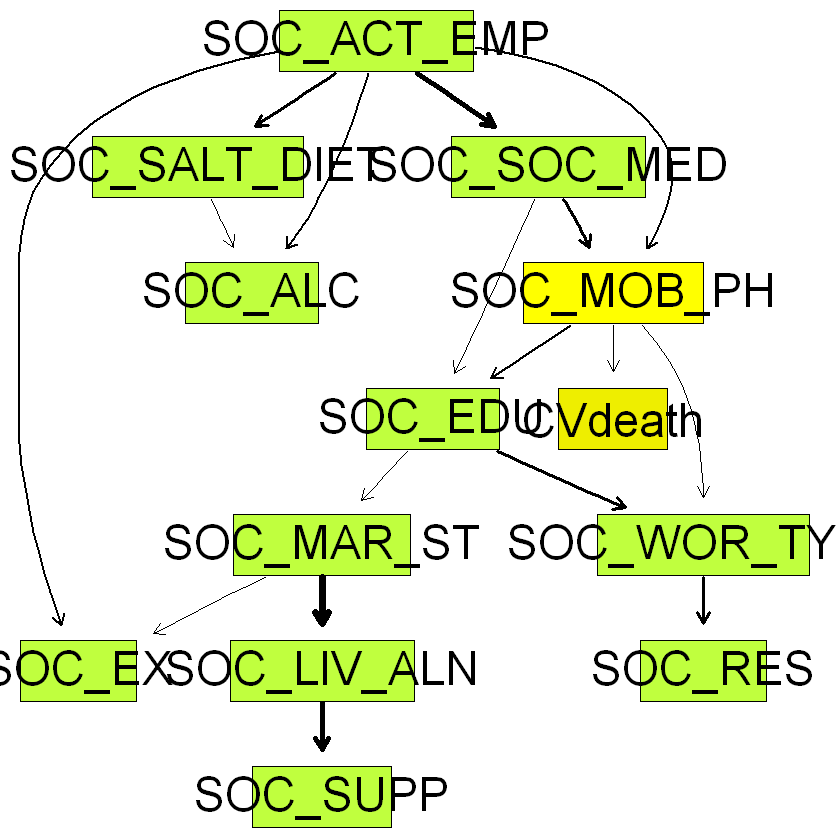

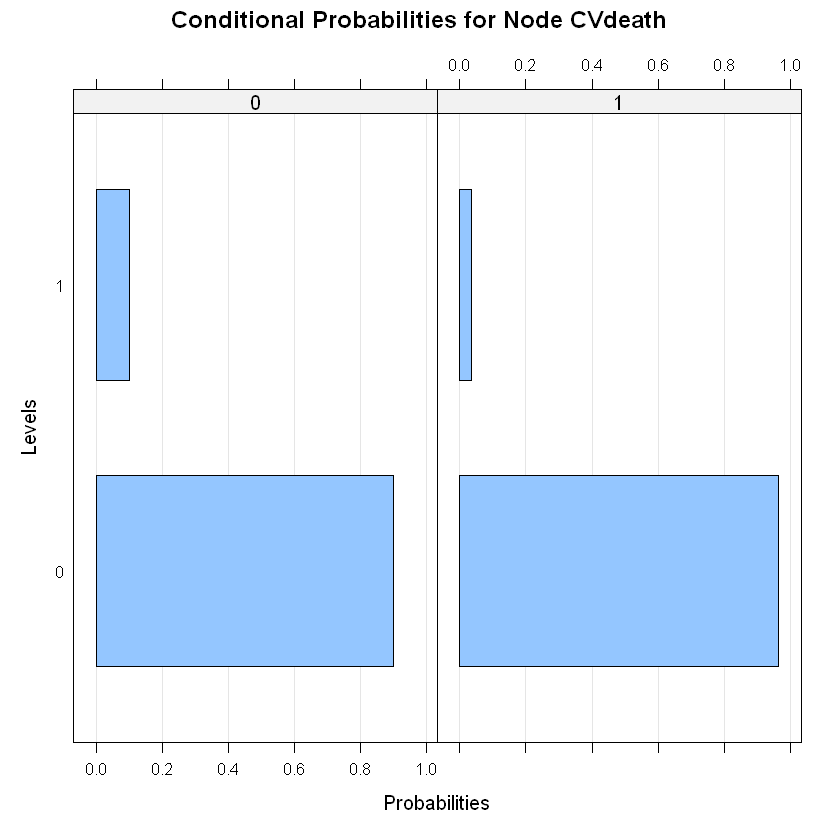

In [189]:
file <- "DATA.csv"
target <- "CVdeath"
predictor_prefixes <- c("SOC")
n_iter <- 200
threshold <- 100
seed <- 1
# Execute the analysis
result <- perform_analysis(file, target, predictor_prefixes, n_iter, threshold, seed)


	Mutual Information (disc.)

data:  SOC_MOB_PH ~ CVdeath  
mi = 17.935, df = 1, p-value = 2.286e-05
alternative hypothesis: true value is greater than 0



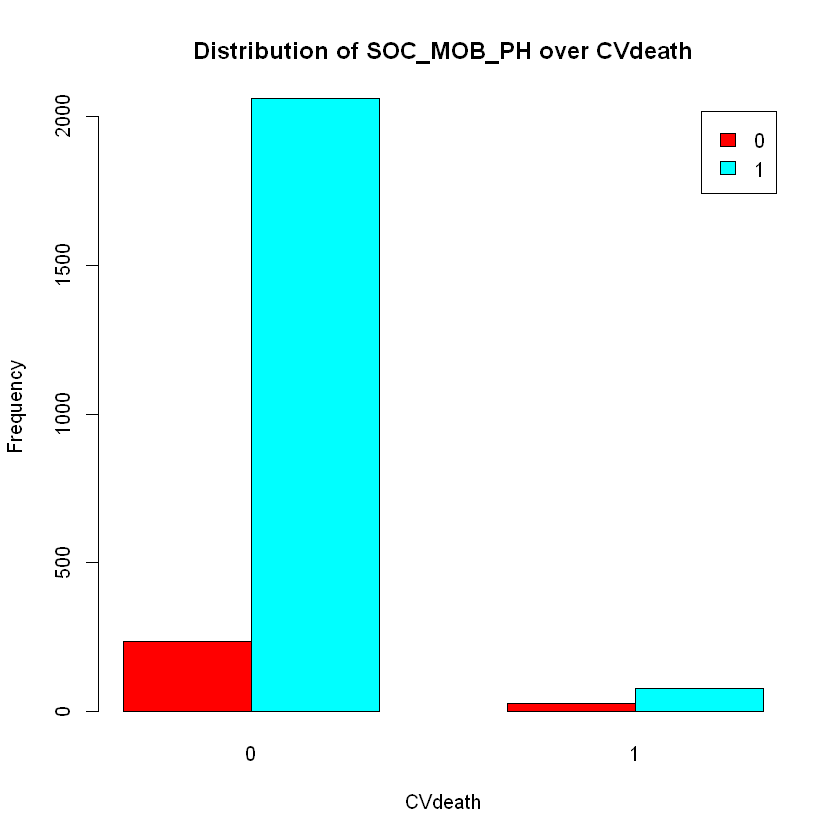

In [95]:
compare_variables("DATA.csv", "SOC_MOB_PH", "CVdeath")

In [96]:
cond_prob <- cpquery(result$bn_fitted, 
                     event = (CVdeath == "1"), 
                     evidence = (SOC_MOB_PH == "0"))
print(cond_prob)

cond_prob <- cpquery(result$bn_fitted, 
                     event = (CVdeath == "1"), 
                     evidence = (SOC_MOB_PH == "1"))
print(cond_prob)


query1 <- querygrain(result$junction, nodes = c("CVdeath"), evidence = list(SOC_MOB_PH = "0"))
print(query1)
query2 <- querygrain(result$junction, nodes = c("CVdeath"), evidence = list(SOC_MOB_PH = "1"))
print(query2)

[1] 0.1070111
[1] 0.03616637
$CVdeath
CVdeath
  0   1 
0.9 0.1 

$CVdeath
CVdeath
         0          1 
0.96432749 0.03567251 



In [97]:
query3 <- querygrain(result$junction, nodes = c("SOC_LIV_ALN"), evidence = list(SOC_MAR_ST = "1"))
print(query3)
query4 <- querygrain(result$junction, nodes = c("SOC_LIV_ALN"), evidence = list(SOC_MAR_ST = "2"))
print(query4)

$SOC_LIV_ALN
SOC_LIV_ALN
         1          2 
0.99038177 0.00961823 

$SOC_LIV_ALN
SOC_LIV_ALN
        1         2 
0.5351865 0.4648135 



In [98]:
query5 <- querygrain(result$junction, nodes = c("SOC_SOC_MED"), evidence = list(SOC_ACT_EMP = "1"))
print(query5)
query6 <- querygrain(result$junction, nodes = c("SOC_SOC_MED"), evidence = list(SOC_ACT_EMP = "2"))
print(query6)

$SOC_SOC_MED
SOC_SOC_MED
        0         1 
0.8052933 0.1947067 



$SOC_SOC_MED
SOC_SOC_MED
        0         1 
0.5030651 0.4969349 



In [99]:
query7 <- querygrain(result$junction, nodes = c("SOC_SUPP"), evidence = list(SOC_LIV_ALN = "1"))
print(query7)
query8 <- querygrain(result$junction, nodes = c("SOC_SUPP"), evidence = list(SOC_LIV_ALN = "2"))
print(query8)

$SOC_SUPP
SOC_SUPP
          0           1 
0.004017531 0.995982469 

$SOC_SUPP
SOC_SUPP
        0         1 
0.1536797 0.8463203 



In [100]:
query9 <- querygrain(result$junction, nodes = c("SOC_MOB_PH"), evidence = list(SOC_SOC_MED = "0"))
print(query9)
query10 <- querygrain(result$junction, nodes = c("SOC_MOB_PH"), evidence = list(SOC_SOC_MED = "1"))
print(query10)

$SOC_MOB_PH
SOC_MOB_PH
        0         1 
0.1488044 0.8511956 



$SOC_MOB_PH
SOC_MOB_PH
          0           1 
0.006395786 0.993604214 



Warning message in check.data(x, allow.missing = TRUE):
"variable MH_BMI in the data has levels that are not observed in the data."
Warning message in check.data(x, allow.missing = TRUE):
"variable MH_BMI in the data has levels that are not observed in the data."


           from           to Freq
1        MH_AGE  SOC_ACT_EMP  200
2        MH_AGE  SOC_SOC_MED  200
3   SOC_LIV_ALN     SOC_SUPP  200
4    SOC_MAR_ST  SOC_LIV_ALN  199
5        MH_SMK       SOC_EX  198
6       TRT_IND       TRT_EF  198
7        MH_AGE   SOC_MOB_PH  197
8       TRT_IND      TRT_ACC  195
9        MH_SEX   SOC_MAR_ST  194
10       MH_SEX      SOC_ALC  192
11       MH_HTN       MH_CKD  190
12       MH_AGE      SOC_EDU  187
13 SOC_WOR_TYPE      SOC_RES  187
14      SOC_EDU SOC_WOR_TYPE  185
15       MH_CKD      CVdeath  183
16       MH_AGE       MH_HGB  182
17       MH_HTN       MH_DLP  180
18       MH_AGE   SOC_MAR_ST  175
19      TRT_DEC      TRT_LCA  169
20       MH_AGE       MH_SMK  168
      from           to            
 [1,] "MH_AGE"       "SOC_ACT_EMP" 
 [2,] "MH_AGE"       "SOC_SOC_MED" 
 [3,] "SOC_LIV_ALN"  "SOC_SUPP"    
 [4,] "SOC_MAR_ST"   "SOC_LIV_ALN" 
 [5,] "MH_SMK"       "SOC_EX"      
 [6,] "TRT_IND"      "TRT_EF"      
 [7,] "MH_AGE"       "SOC_MOB_PH" 

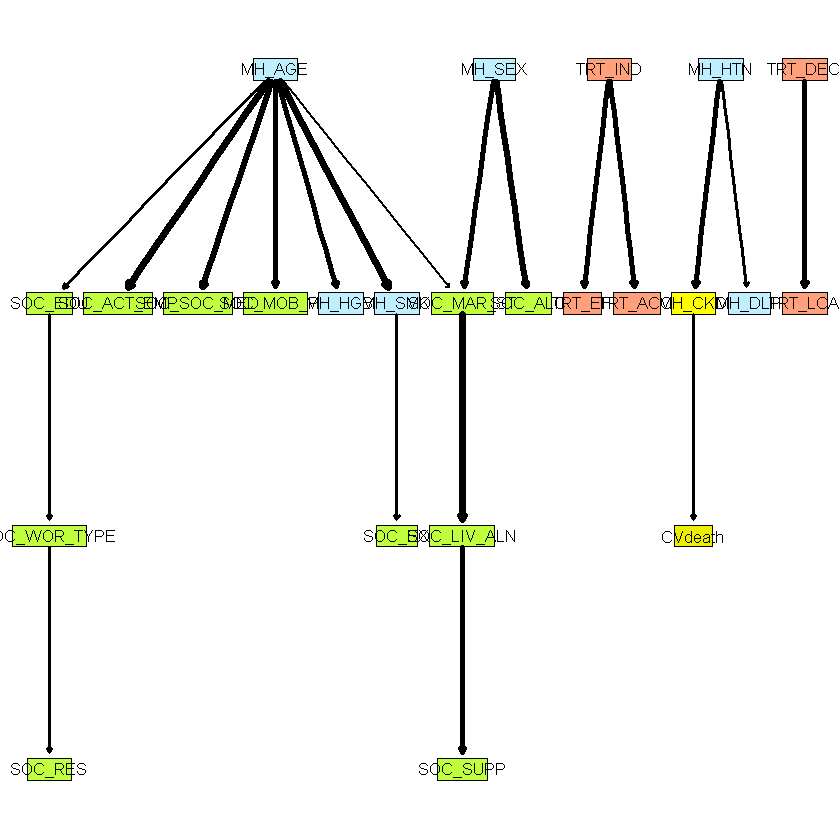

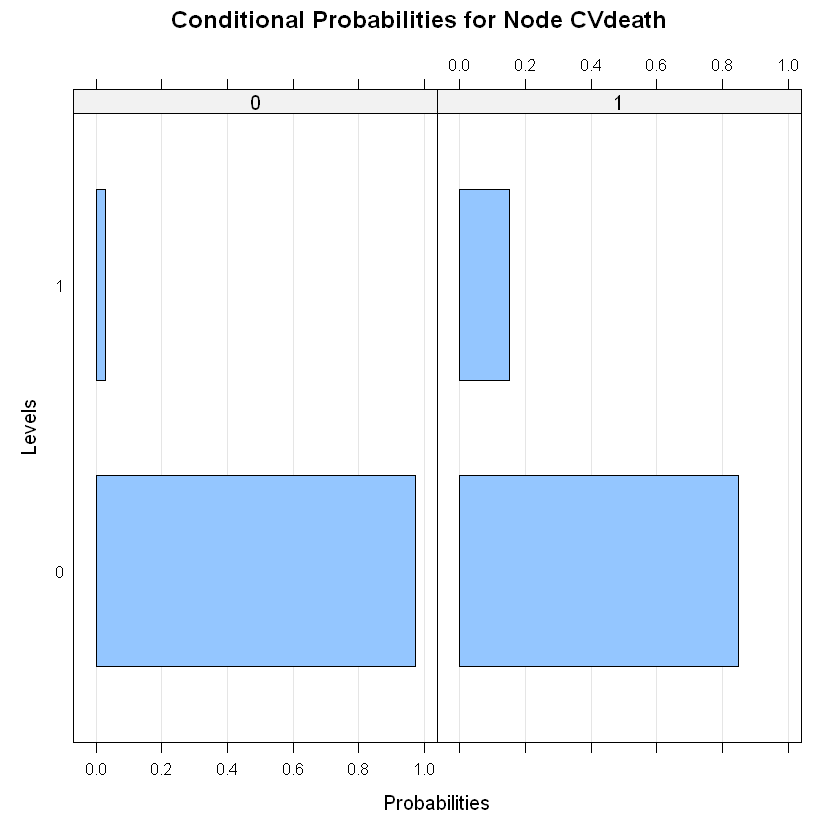

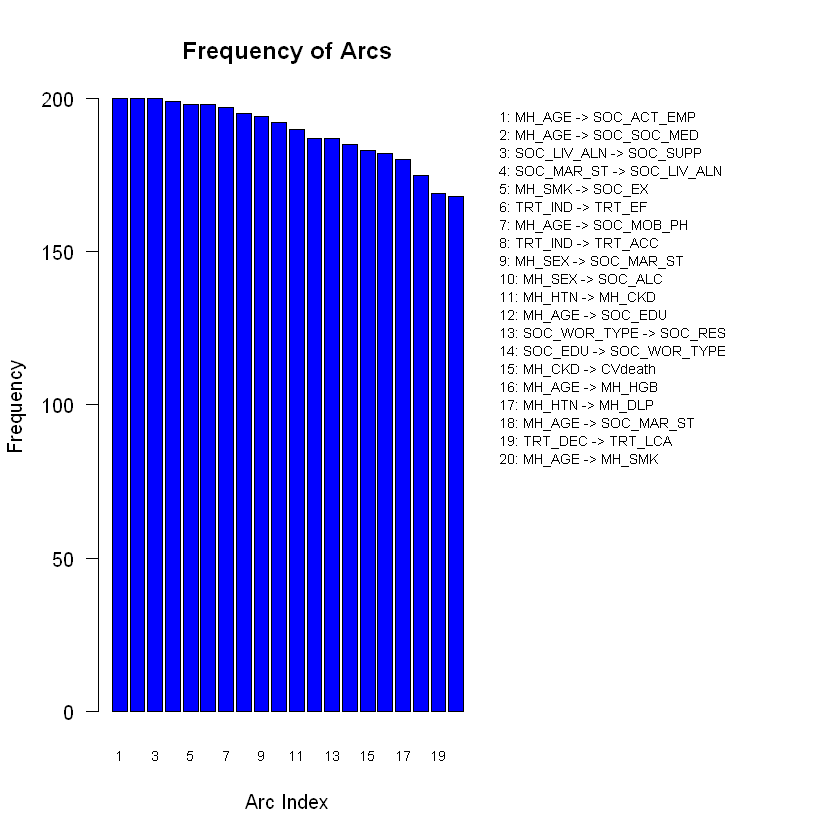

In [185]:
file <- "DATA.csv"
target <- "CVdeath"
predictor_prefixes <- c("MH", "TRT", "SOC")
n_iter <- 200
threshold <- 150
seed <- 1
# Execute the analysis
result_CVdeath <- perform_analysis(file, target, predictor_prefixes, n_iter, threshold, seed)

In [102]:
query11 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_CKD = "0"))
print(query11)
query12 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_CKD = "1"))
print(query12)

$CVdeath
CVdeath
         0          1 
0.97158689 0.02841311 

$CVdeath
CVdeath
        0         1 
0.8488372 0.1511628 



In [103]:
query13 <- querygrain(result_CVdeath$junction, nodes = c("SOC_ACT_EMP"), evidence = list(MH_AGE = "1"))
print(query13)
query14 <- querygrain(result_CVdeath$junction, nodes = c("SOC_ACT_EMP"), evidence = list(MH_AGE = "2"))
print(query14)
query15 <- querygrain(result_CVdeath$junction, nodes = c("SOC_ACT_EMP"), evidence = list(MH_AGE = "3"))
print(query15)

$SOC_ACT_EMP
SOC_ACT_EMP
        1         2 
0.3355042 0.6644958 

$SOC_ACT_EMP
SOC_ACT_EMP
        1         2 
0.8643027 0.1356973 

$SOC_ACT_EMP
SOC_ACT_EMP
         1          2 
0.98540941 0.01459059 



In [104]:
query16 <- querygrain(result_CVdeath$junction, nodes = c("TRT_LAD"), evidence = list(TRT_DEC = "1"))
print(query16)
query17 <- querygrain(result_CVdeath$junction, nodes = c("TRT_LAD"), evidence = list(TRT_DEC = "2"))
print(query17)
query18 <- querygrain(result_CVdeath$junction, nodes = c("TRT_LAD"), evidence = list(TRT_DEC = "3"))
print(query18)

$TRT_LAD
TRT_LAD
        0         1 
0.3370956 0.6629044 

$TRT_LAD
TRT_LAD
        0         1 
0.3016704 0.6983296 

$TRT_LAD
TRT_LAD
        0         1 
0.6485302 0.3514698 



In [105]:
nparams(result_CVdeath$bn_fitted) # Number of parameters in the network

[1] 113

Warning message in check.data(x, allow.missing = TRUE):
"variable MH_BMI in the data has levels that are not observed in the data."
Warning message in check.data(x, allow.missing = TRUE):
"variable MH_BMI in the data has levels that are not observed in the data."


             from            to Freq
1          MH_AGE   SOC_ACT_EMP  200
2          MH_AGE   SOC_SOC_MED  200
3     SOC_LIV_ALN      SOC_SUPP  200
4      SOC_MAR_ST   SOC_LIV_ALN  199
5          MH_SMK        SOC_EX  198
6         TRT_IND        TRT_EF  198
7          MH_AGE    SOC_MOB_PH  197
8         TRT_IND       TRT_ACC  195
9          MH_SEX    SOC_MAR_ST  194
10         MH_SEX       SOC_ALC  192
11         MH_HTN        MH_CKD  190
12         MH_AGE       SOC_EDU  187
13   SOC_WOR_TYPE       SOC_RES  187
14        SOC_EDU  SOC_WOR_TYPE  185
15         MH_AGE        MH_HGB  182
16         MH_HTN        MH_DLP  180
17         MH_AGE    SOC_MAR_ST  175
18        TRT_DEC       TRT_LCA  169
19         MH_AGE        MH_SMK  168
20        TRT_LCX       TRT_LAD  165
21     SOC_MOB_PH   SOC_SOC_MED  164
22        TRT_RCA       TRT_LAD  163
23         MH_AGE        MH_CKD  162
24         MH_AGE     MH_FHxIHD  162
25        TRT_LAD        TRT_EF  162
26         MH_HTN        MH_BMI  156
2

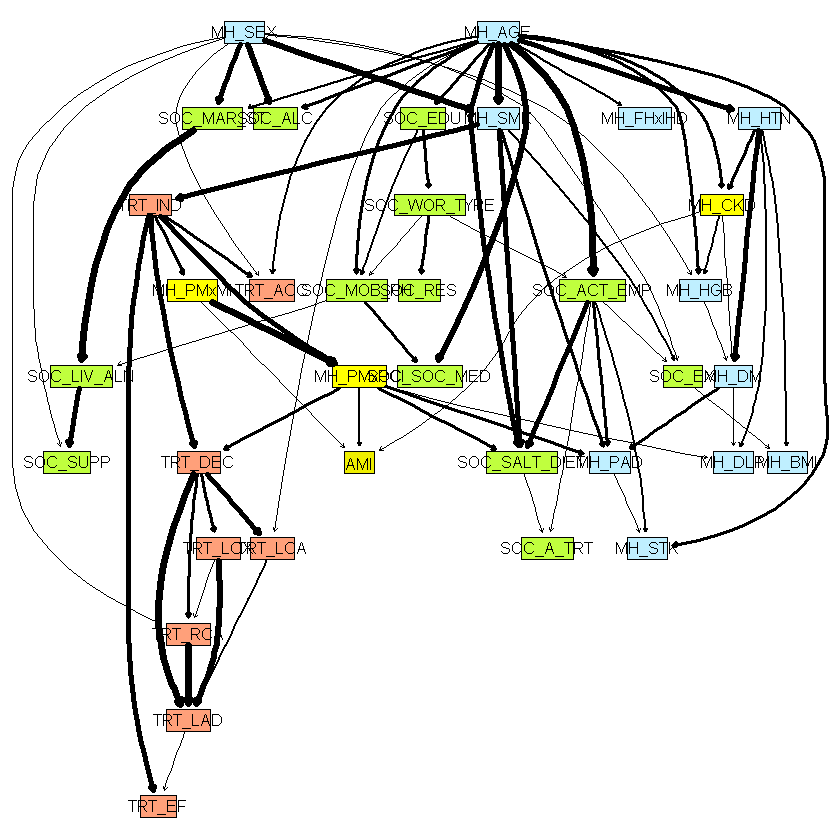

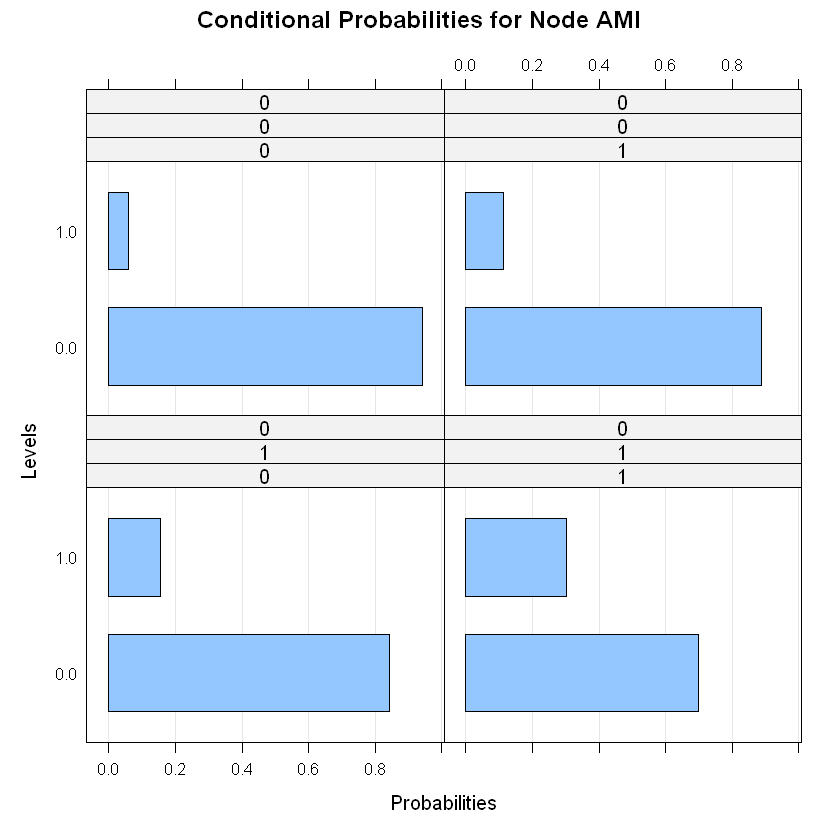

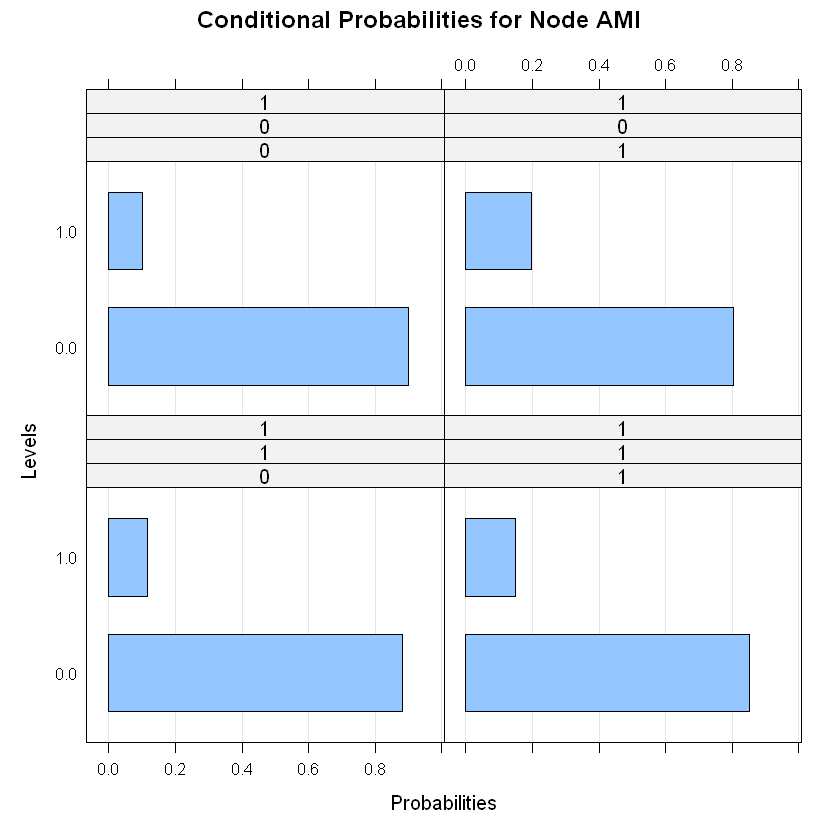

In [107]:
file <- "DATA.csv"
target <- "AMI"
predictor_prefixes <- c("MH", "TRT", "SOC")
n_iter <- 200
threshold <- 50
seed <- 1
# Execute the analysis
result_AMI <- perform_analysis(file, target, predictor_prefixes, n_iter, threshold, seed)

In [108]:
query19 <- querygrain(result_AMI$junction, nodes = c("AMI"), evidence = list(MH_PMxPCI = "0"))
print(query19)
query20 <- querygrain(result_AMI$junction, nodes = c("AMI"), evidence = list(MH_PMxPCI = "1"))
print(query20)

$AMI
AMI
       0.0        1.0 
0.93009051 0.06990949 

$AMI
AMI
    0.0     1.0 
0.88198 0.11802 



In [109]:
query21 <- querygrain(result_AMI$junction, nodes = c("AMI"), evidence = list(MH_PMxMI = "0"))
print(query21)
query22 <- querygrain(result_AMI$junction, nodes = c("AMI"), evidence = list(MH_PMxMI = "1"))
print(query22)

$AMI
AMI
       0.0        1.0 
0.92784787 0.07215213 

$AMI
AMI
      0.0       1.0 
0.8711212 0.1288788 



In [110]:
query23 <- querygrain(result_AMI$junction, nodes = c("AMI"), evidence = list(MH_CKD = "0"))
print(query23)
query24 <- querygrain(result_AMI$junction, nodes = c("AMI"), evidence = list(MH_CKD = "1"))
print(query24)

$AMI
AMI
       0.0        1.0 
0.92367045 0.07632955 

$AMI
AMI
      0.0       1.0 
0.8655044 0.1344956 



In [112]:
nparams(result_AMI$bn_fitted) # Number of parameters in the network

[1] 319

Warning message in check.data(x, allow.missing = TRUE):
"variable MH_BMI in the data has levels that are not observed in the data."
Warning message in check.data(x, allow.missing = TRUE):
"variable MH_BMI in the data has levels that are not observed in the data."


             from            to Freq
1          MH_AGE   SOC_ACT_EMP  200
2          MH_AGE   SOC_SOC_MED  200
3     SOC_LIV_ALN      SOC_SUPP  200
4      SOC_MAR_ST   SOC_LIV_ALN  199
5          MH_SMK        SOC_EX  198
6         TRT_IND        TRT_EF  198
7          MH_AGE    SOC_MOB_PH  197
8         TRT_IND       TRT_ACC  195
9          MH_SEX    SOC_MAR_ST  194
10         MH_SEX       SOC_ALC  192
11         MH_HTN        MH_CKD  190
12         MH_AGE       SOC_EDU  187
13   SOC_WOR_TYPE       SOC_RES  187
14        SOC_EDU  SOC_WOR_TYPE  185
15         MH_AGE        MH_HGB  182
16         MH_HTN        MH_DLP  180
17         MH_AGE    SOC_MAR_ST  175
18        TRT_DEC       TRT_LCA  169
19         MH_AGE        MH_SMK  168
20    SOC_ACT_EMP    HEMORRHAGE  167
21     SOC_MOB_PH   SOC_SOC_MED  164
22        TRT_LCX       TRT_LAD  164
23        TRT_RCA       TRT_LAD  163
24         MH_AGE        MH_CKD  162
25         MH_AGE     MH_FHxIHD  162
26        TRT_LAD        TRT_EF  162
2

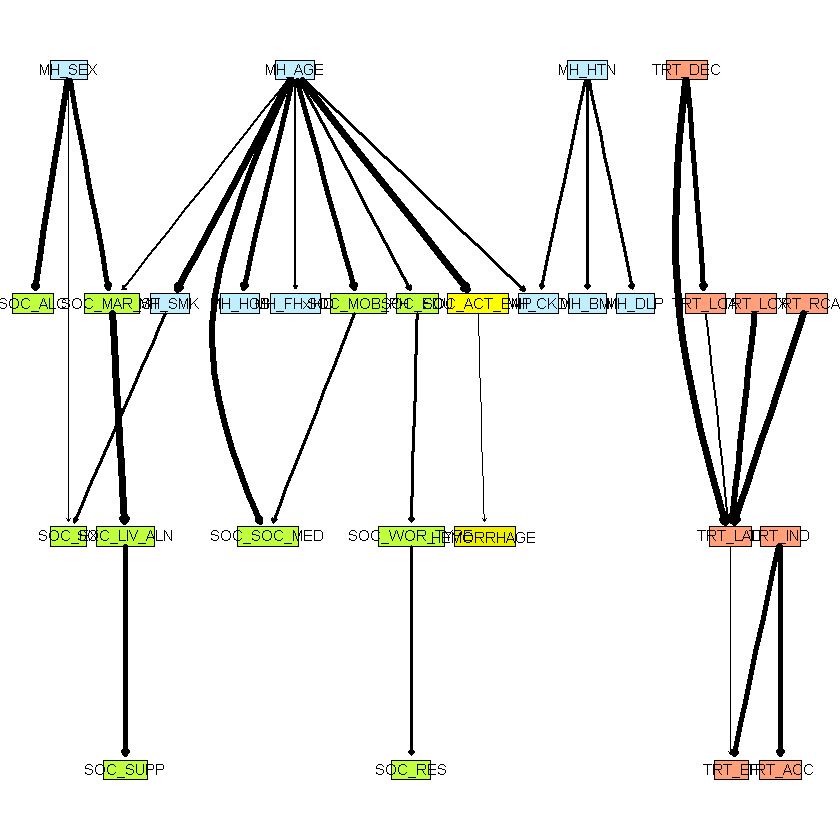

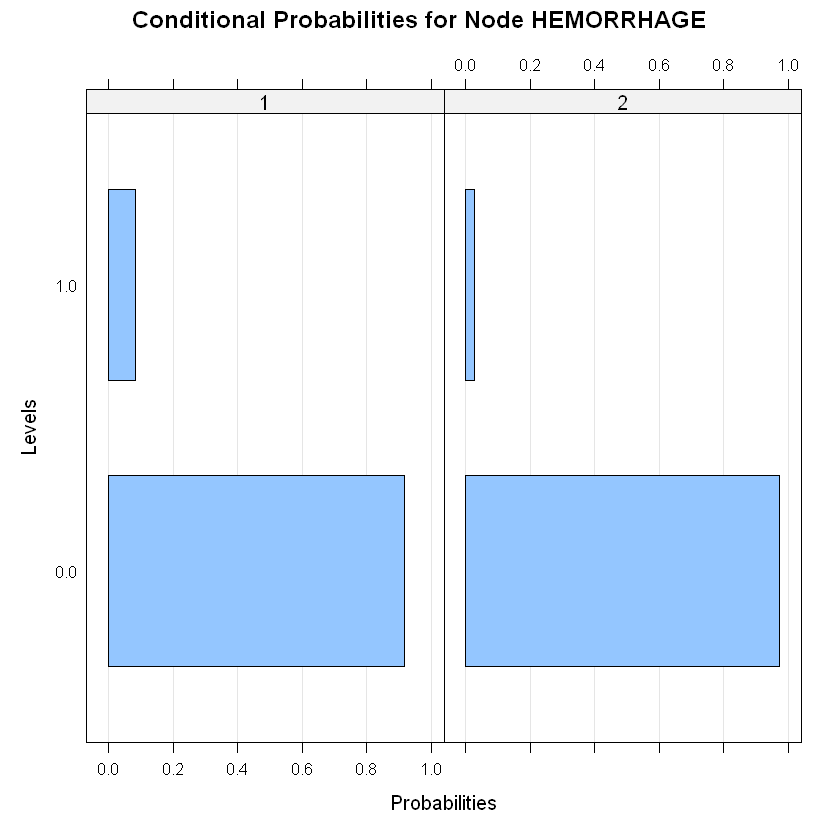

In [113]:
file <- "DATA.csv"
target <- "HEMORRHAGE"
predictor_prefixes <- c("MH", "TRT", "SOC")
n_iter <- 200
threshold <- 150
seed <- 1
# Execute the analysis
result_HEMORRHAGE <- perform_analysis(file, target, predictor_prefixes, n_iter, threshold, seed)

In [115]:
query25 <- querygrain(result_HEMORRHAGE$junction, nodes = c("HEMORRHAGE"), evidence = list(SOC_ACT_EMP = "1"))
print(query25)
query26 <- querygrain(result_HEMORRHAGE$junction, nodes = c("HEMORRHAGE"), evidence = list(SOC_ACT_EMP = "2"))
print(query26)

$HEMORRHAGE
HEMORRHAGE
     0.0      1.0 
0.931875 0.068125 



$HEMORRHAGE
HEMORRHAGE
       0.0        1.0 
0.91688126 0.08311874 



In [116]:
nparams(result_HEMORRHAGE$bn_fitted) # Number of parameters in the network

[1] 113

In [118]:
# We also can use the following function to check the d-separation
dsep(result_CVdeath$BNet, "CVdeath", "SOC_ACT_EMP", "MH_AGE")

[1] TRUE

In [140]:
query27 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_AGE = "1"))
print(query27)
query28 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_AGE = "2"))
print(query28)
query29 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_AGE = "3"))
print(query29)

$CVdeath
CVdeath
         0          1 
0.96580911 0.03419089 

$CVdeath
CVdeath
         0          1 
0.96042725 0.03957275 

$CVdeath
CVdeath
         0          1 
0.94757567 0.05242433 



In [143]:
query30 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_BMI = "1"))
print(query30)
query31 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_BMI = "2"))
print(query31)
query32 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_BMI = "3"))
print(query32)
query33 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_BMI = "4"))
print(query33)

$CVdeath
CVdeath
         0          1 
0.95706344 0.04293656 



$CVdeath
CVdeath
         0          1 
0.95982455 0.04017545 

$CVdeath
CVdeath
         0          1 
0.95837304 0.04162696 

$CVdeath
CVdeath
         0          1 
0.95650509 0.04349491 



In [149]:
query34 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_HTN = "0"))
print(query34)
query35 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_HTN = "1"))
print(query35)

$CVdeath
CVdeath
         0          1 
0.96789384 0.03210616 



$CVdeath
CVdeath
         0          1 
0.95316449 0.04683551 



In [151]:
query36 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_DLP = "0"))
print(query36)
query37 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_DLP = "1"))
print(query37)

$CVdeath
CVdeath
         0          1 
0.95980849 0.04019151 



$CVdeath
CVdeath
         0          1 
0.95707041 0.04292959 



In [152]:
query38 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_HGB = "1"))
print(query38)
query39 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_HGB = "2"))
print(query39)

$CVdeath
CVdeath
         0          1 
0.95936845 0.04063155 

$CVdeath
CVdeath
         0          1 
0.95571284 0.04428716 



In [154]:
query40 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_FHxIHD = "0"))
print(query40)
query41 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(MH_FHxIHD = "1"))
print(query41)

$CVdeath
CVdeath
         0          1 
0.95724443 0.04275557 



$CVdeath
CVdeath
         0          1 
0.95943191 0.04056809 



In [155]:
query42 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_MAR_ST = "1"))
print(query42)
query43 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_MAR_ST = "2"))
print(query43)

$CVdeath
CVdeath
         0          1 
0.95793194 0.04206806 

$CVdeath
CVdeath
         0          1 
0.95854465 0.04145535 



In [156]:
query44 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_LIV_ALN = "1"))
print(query44)
query45 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_LIV_ALN = "2"))
print(query45)

$CVdeath
CVdeath
         0          1 
0.95804158 0.04195842 

$CVdeath
CVdeath
         0          1 
0.95851474 0.04148526 



In [158]:
query46 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_SUPP = "0"))
print(query46)
query47 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_SUPP = "1"))
print(query47)

$CVdeath
CVdeath
         0          1 
0.95844948 0.04155052 

$CVdeath
CVdeath
         0          1 
0.95809926 0.04190074 



In [159]:
query48 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_RES = "1"))
print(query48)
query49 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_RES = "2"))
print(query49)

$CVdeath
CVdeath
         0          1 
0.95807687 0.04192313 

$CVdeath
CVdeath
         0          1 
0.95814916 0.04185084 



In [160]:
query50 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_EDU = "0"))
print(query50)
query51 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_EDU = "1"))
print(query51)

$CVdeath
CVdeath
         0          1 
0.95223971 0.04776029 

$CVdeath
CVdeath
         0          1 
0.95852299 0.04147701 



In [161]:
query52 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_ACT_EMP = "1"))
print(query52)
query53 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_ACT_EMP = "2"))
print(query53)

$CVdeath
CVdeath
         0          1 
0.95570063 0.04429937 

$CVdeath
CVdeath
         0          1 
0.96455542 0.03544458 



In [162]:
query54 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_WOR_TYPE = "1"))
print(query54)
query55 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_WOR_TYPE = "2"))
print(query55)

$CVdeath
CVdeath
         0          1 
0.95847838 0.04152162 

$CVdeath
CVdeath
         0          1 
0.95794309 0.04205691 



In [163]:
query56 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_EX = "0"))
print(query56)
query57 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_EX = "1"))
print(query57)

$CVdeath
CVdeath
         0          1 
0.95897025 0.04102975 

$CVdeath
CVdeath
         0          1 
0.95765445 0.04234555 



In [167]:
query58 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_SOC_MED = "0"))
print(query58)
query59 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_SOC_MED = "1"))
print(query59)

$CVdeath
CVdeath
         0          1 
0.95633887 0.04366113 



$CVdeath
CVdeath
         0          1 
0.96272859 0.03727141 



In [168]:
query60 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_MOB_PH = "0"))
print(query60)
query61 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_MOB_PH = "1"))
print(query61)

$CVdeath
CVdeath
         0          1 
0.95218742 0.04781258 

$CVdeath
CVdeath
         0          1 
0.95883512 0.04116488 



In [169]:
query62 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_A_TRT = "0"))
print(query62)
query63 <- querygrain(result_CVdeath$junction, nodes = c("CVdeath"), evidence = list(SOC_A_TRT = "1"))
print(query63)

$CVdeath
CVdeath
         0          1 
0.95810803 0.04189197 

$CVdeath
CVdeath
         0          1 
0.95810803 0.04189197 

